In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import ipywidgets as widgets
from matplotlib import animation
from functools import partial
slider_layout = widgets.Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
IntSlider_nice = partial(widgets.IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
FloatSlider_nice = partial(widgets.FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelSlider_nice = partial(widgets.SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Árboles de decisión y Métodos de ensamble

Slides [aquí](https://docs.google.com/presentation/d/1pxJk4cpI_gpvLhDi86EISHjggdyD95K6PgwKlJplkTg/edit?usp=sharing)

Material adicional: Capítulos 10 (boosting) y 15 (bagging, random forest) de "Elements of Statistical Learning" (ver README del repo)

<IPython.core.display.Javascript object>


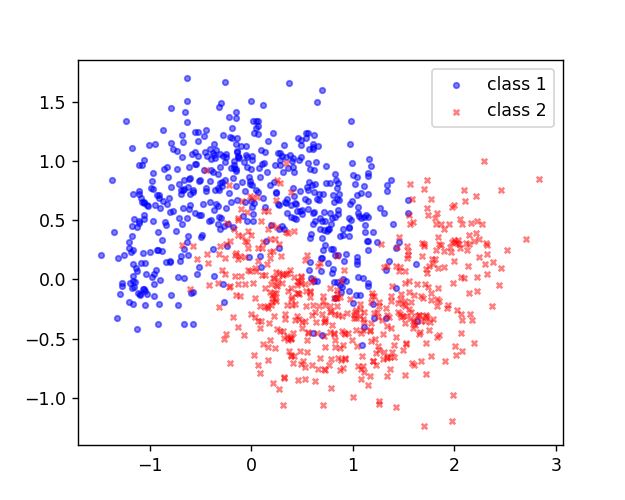

In [16]:
from sklearn.datasets import make_blobs, make_moons

N = 1000  
X, Y = make_moons(n_samples=N, noise=0.3)
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(X[Y==0, 0], X[Y==0, 1], c='b', marker='o', 
           s=10, alpha=0.5, label='class 1')
ax.scatter(X[Y==1, 0], X[Y==1, 1], c='r', marker='x', 
           s=10, alpha=0.5, label='class 2')
plt.legend()

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))


# Árbol de decisión con Scikit-Learn

- Secuencia de operadores relacionales sobre los atributos en forma de árbol
- Los nodos "hoja" están asociados a una etiqueta (clasificación)
- Los nodos intermedios separan los datos (*splits*)
- Las separaciones se seleccionan usando la ganancia de información (*entropy*) o el índice de gini 
- Se puede controlar la profunidad máxima del árbol: *max_depth*



<IPython.core.display.Javascript object>


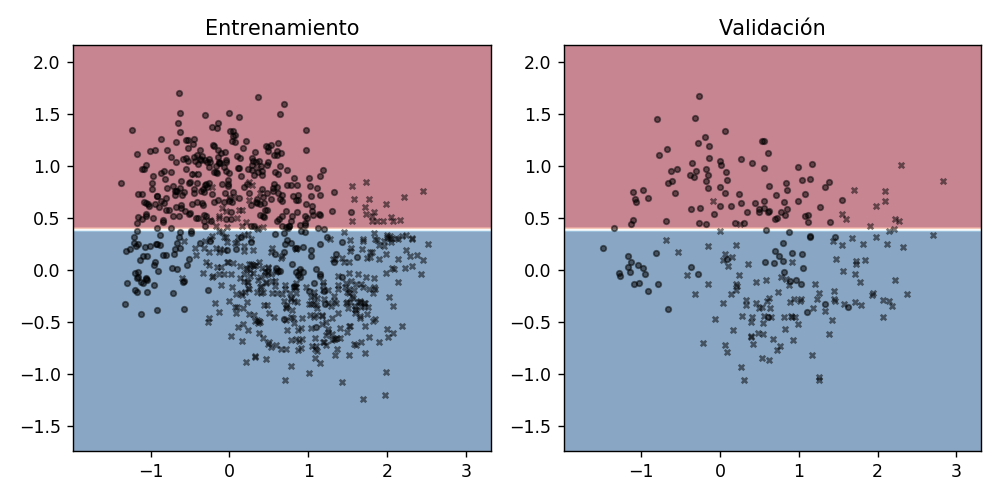

interactive(children=(IntSlider(value=1, continuous_update=False, description='md', layout=Layout(height='20px…

In [17]:
from sklearn import tree

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

def update_plot(md):
    model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=md)
    model.fit(X_train, Y_train)
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    for ax_ in ax:
        ax_.cla()
        ax_.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
    ax[0].set_title('Entrenamiento'); ax[1].set_title('Validación')
    ax[0].scatter(X_train[Y_train==0, 0], X_train[Y_train==0, 1], color='k', s=10, marker='o', alpha=0.5)
    ax[0].scatter(X_train[Y_train==1, 0], X_train[Y_train==1, 1], color='k', s=10, marker='x', alpha=0.5)
    ax[1].scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='k', s=10, marker='o', alpha=0.5)
    ax[1].scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='k', s=10, marker='x', alpha=0.5)


widgets.interact(update_plot, md=IntSlider_nice(min=1, max=51));

<IPython.core.display.Javascript object>


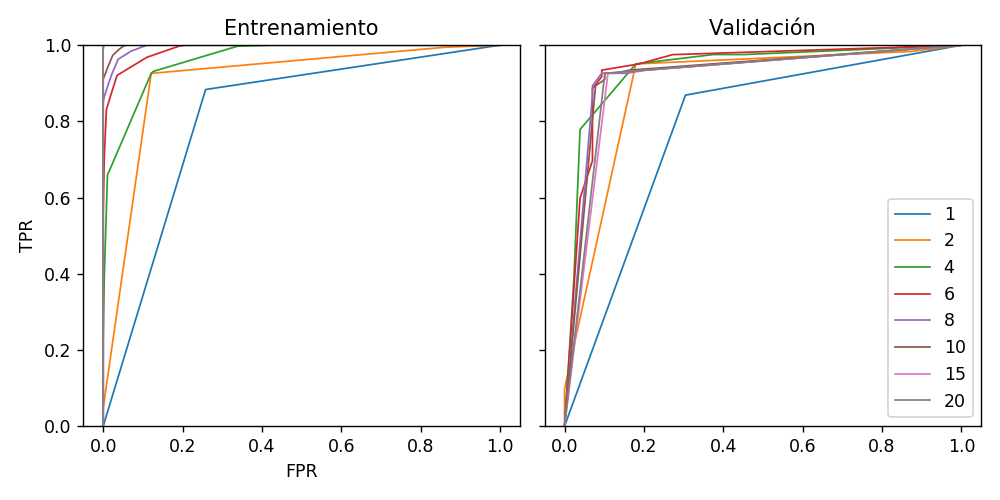

1   0.7820824795081966
2   0.8907530737704917
4   0.9396452356557377
6   0.9417264344262295
8   0.9241162909836065
10   0.9226114241803278
15   0.9084272540983607
20   0.9123335040983607


In [18]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharex=True, sharey=True)
ax[0].set_title('Entrenamiento')
ax[1].set_title('Validación')
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_ylim([0.0, 1.0])


for max_depth in [1, 2, 4, 6, 8, 10, 15, 20]:
    model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=max_depth)
    model.fit(X_train, Y_train)
    fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
    ax[0].plot(fpr, tpr, label=str(max_depth), linewidth=1)
    fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
    ax[1].plot(fpr, tpr, label=str(max_depth), linewidth=1)
    print(max_depth, " ", auc(fpr, tpr))
plt.legend(loc=4);

In [27]:
from sklearn.model_selection import GridSearchCV

params = {'criterion':('entropy', 'gini'), 'max_depth':[1, 2, 4, 5, 6, 8, 10, 20, 50]}
model = tree.DecisionTreeClassifier(splitter='best')
dts = GridSearchCV(model, params, cv=5)
dts.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [1, 2, 4, 5, 6, 8, 10, 20, 50]},
      

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


<IPython.core.display.Javascript object>


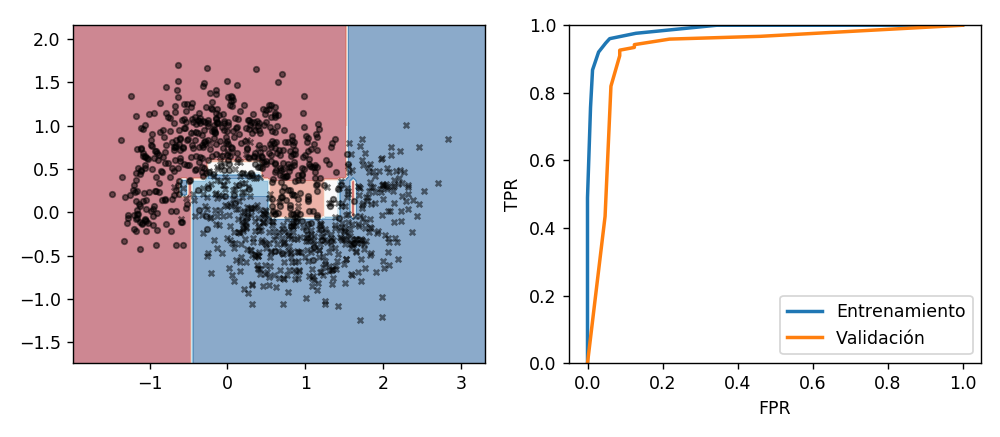

Entrenamiento: 0.950667
Validación: 0.908000


In [28]:
model = dts.best_estimator_
print(model)
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)

print("Entrenamiento: %f" % (model.score(X_train, Y_train)))
print("Validación: %f" % (model.score(X_test, Y_test)))

ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax[0].scatter(X[Y==0, 0], X[Y==0, 1], color='k', s=10, marker='o', alpha=0.5)
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='k', s=10, marker='x', alpha=0.5)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax[1].plot(fpr, tpr, label='Entrenamiento', linewidth=2)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax[1].plot(fpr, tpr, label='Validación', linewidth=2)
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax[1].set_ylim([0.0, 1.0]);


# Gradient Boosting con Scikit-Learn

- Generaliza el concepto de boosting a cualquier función de costo derivable
- Cada clasificador en la cadena se entrena con los residuos del clasificador anterior
- Esta implementación usa árboles como clasificador débil

Parámetros ajustables:
- n_estimators: Número de árboles
- max_depth: Profundidad de los árboles
- subsample: Se usa para que cada árbol use una submuestra del dataset
- learning_rate: Se usa para disminuir la contribución de cada árbol sucesivo
- max_features: Número de atributos a considerar en cada split (reduce la varianza)


In [11]:
ensemble.GradientBoostingClassifier?

In [56]:
params = {'loss':('deviance', 'exponential'), 
          'max_depth':[1, 5, 10, 20],
          'n_estimators': [1, 10, 20, 50, 100]}
model = ensemble.GradientBoostingClassifier(subsample=0.5, 
                                            learning_rate=0.1, max_features=None)
gbs = GridSearchCV(model, params, cv=5)
gbs.fit(X_train, Y_train)
display(gbs.best_estimator_)
display(gbs.best_score_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=20,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

0.924

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=20,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


<IPython.core.display.Javascript object>


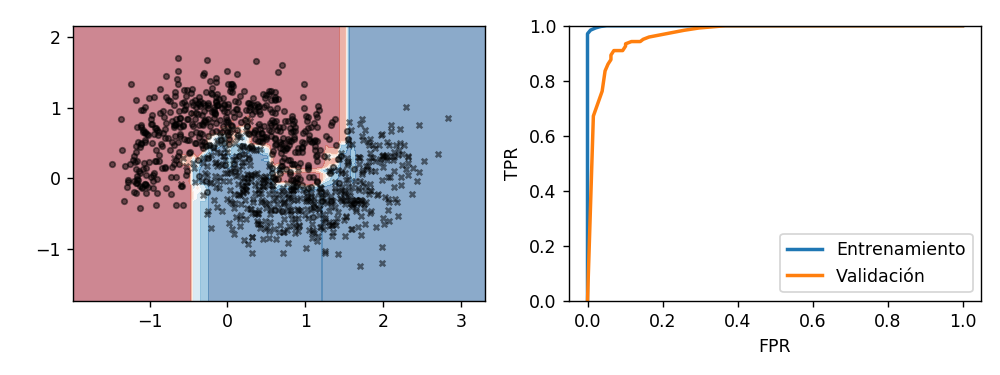

Entrenamiento: 0.985333
Validación: 0.912000


In [57]:
model = gbs.best_estimator_
print(model)
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

print("Entrenamiento: %f" % (model.score(X_train, Y_train)))
print("Validación: %f" % (model.score(X_test, Y_test)))

ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax[0].scatter(X[Y==0, 0], X[Y==0, 1], color='k', s=10, marker='o', alpha=0.5)
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='k', s=10, marker='x', alpha=0.5)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax[1].plot(fpr, tpr, label='Entrenamiento', linewidth=2)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax[1].plot(fpr, tpr, label='Validación', linewidth=2)
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax[1].set_ylim([0.0, 1.0]);

<IPython.core.display.Javascript object>


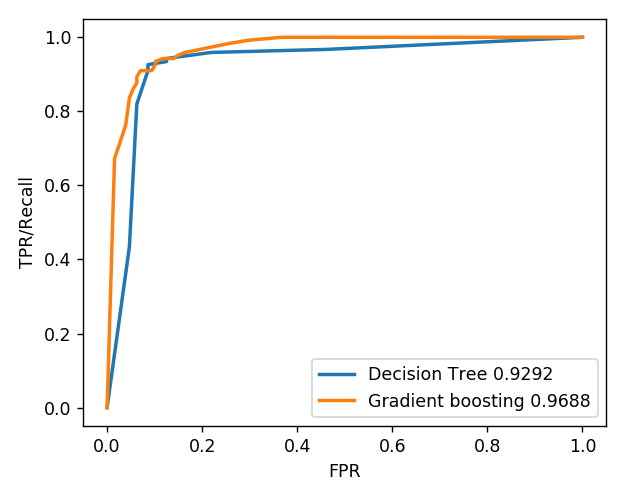

In [58]:
fig, ax = plt.subplots(1, figsize=(5, 4), tight_layout=True)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR/Recall')

Y_pred = dts.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Decision Tree %0.4f" %auc(fpr, tpr), linewidth=2)

Y_pred = gbs.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(Y_test, Y_pred)
ax.plot(fpr, tpr, label="Gradient boosting %0.4f" %auc(fpr, tpr), linewidth=2)
plt.legend(loc=4);


# Random Forest con Scikit-Learn


- Conjunto de árboles de decisión entrenados en paralelo usando bootstrap 
- Cada árbol se entrena con un **subconjunto aleatorio** de los datos (bagging)
- Cada árbol se entrena con un **subconjunto aleatorio** de los atributos (random forest)


In [ ]:
model = ensemble.RandomForestClassifier(max_depth=10, n_estimators=100, criterion='entropy',
                               n_jobs=2, max_features=2)

model.fit(X_train, Y_train)
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
print("Classification score:")
print("Train: %f" % (model.score(X_train, Y_train)))
print("Test: %f" % (model.score(X_test, Y_test)))

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1)
ax.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax.scatter(X[Y==0, 0], X[Y==0, 1], color='k', marker='o', alpha=0.5)
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='k', marker='x', alpha=0.5)
ax = fig.add_subplot(1, 2, 2)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax.plot(fpr, tpr, label='Train', linewidth=4)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, label='Test', linewidth=4)
plt.grid()
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_ylim([0.0, 1.05])